In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import shap
from xgboost import XGBClassifier


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import src.features.build_features as FeaturesManager
import src.features.select_features as FeaturesSelector
import src.features.detect_outliers as OutliersManager

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



In [7]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
data_df = FeaturesManager.build_features(seasons_year, season_type, with_player_stats=True, with_strength_stats=True)

features_to_keep = FeaturesManager.GetFeaturesToKeep()

feature_names, target_name = features_to_keep[0:-1], features_to_keep[-1]
feature_names = np.array(feature_names)

df_features = data_df[feature_names]
df_targets = data_df[target_name]

X = df_features
y = df_targets

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# X_train, y_train = OutliersManager.remove_outliers(X_train, y_train)
# X_valid, y_valid = OutliersManager.remove_outliers(X_valid, y_valid)

In [16]:
numerical_columns = [
    'Period seconds', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 
    'Speed From Previous Event', 'Change in Shot Angle', 
    'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season',
    'Elapsed time since Power Play', 'Last event elapsed time', 'Last event st_X', 'Last event st_Y', 
    'Last event distance', 'Last event angle']

nominal_columns = ['Shot Type', 'Strength', 'Shooter Side', 'Shooter Ice Position']
ordinal_columns = ['Period', 'Num players With', 'Num players Against', 'Is Empty', 'Rebound']

In [18]:
# X_train, X_valid, y_train, y_valid = FeaturesManager.GetTrainValid()

# median
fill_nan = ColumnTransformer(transformers = [
    ('cat', SimpleImputer(strategy ='most_frequent'), nominal_columns + ordinal_columns),
    ('num', SimpleImputer(strategy ='median'), numerical_columns),
], remainder ='passthrough')

# one-hot      
one_hot = ColumnTransformer(transformers = [
    ('enc', OneHotEncoder(sparse = False), list(range(len(nominal_columns)))),
], remainder ='passthrough')

xbg = XGBClassifier(random_state=RANDOM_SEED)
steps = [('fill_nan', fill_nan), ('one_hot', one_hot),  ("xbg", xbg)]
pipeline = Pipeline(steps=steps).fit(X, y)
    
# explain the model's predictions using SHAP
explainer = shap.Explainer(pipeline)
shap_values = explainer(X)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('fill_nan',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Shot Type', 'Strength',
                                                   'Shooter Side',
                                                   'Shooter Ice Position',
                                                   'Period', 'Num players With',
                                                   'Num players Against',
                                                   'Is Empty', 'Rebound']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Period seconds', 'st_X',
                                                   'st_Y', 'Shot distance',
                                                   'Shot an...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

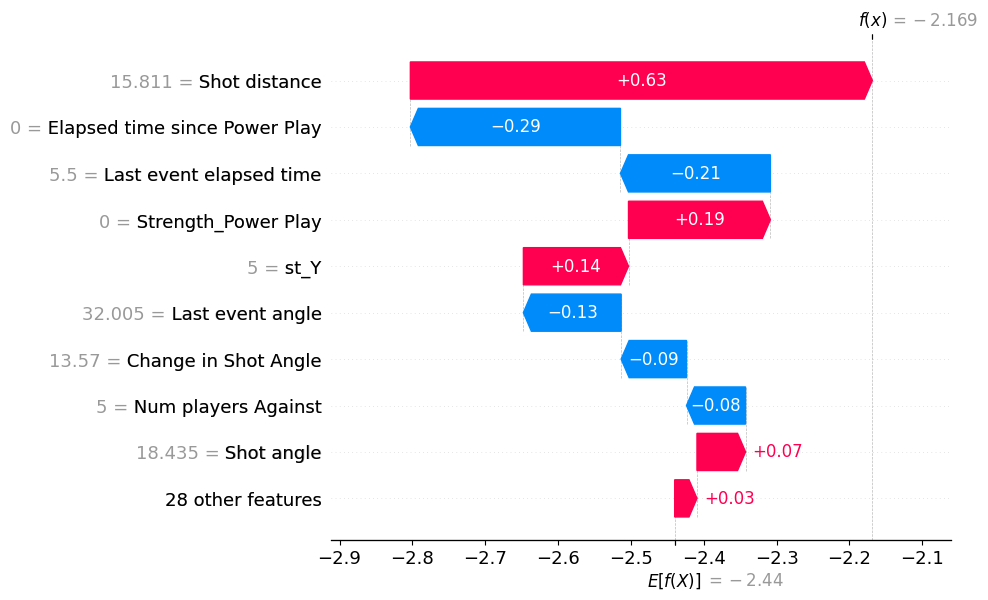

In [11]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

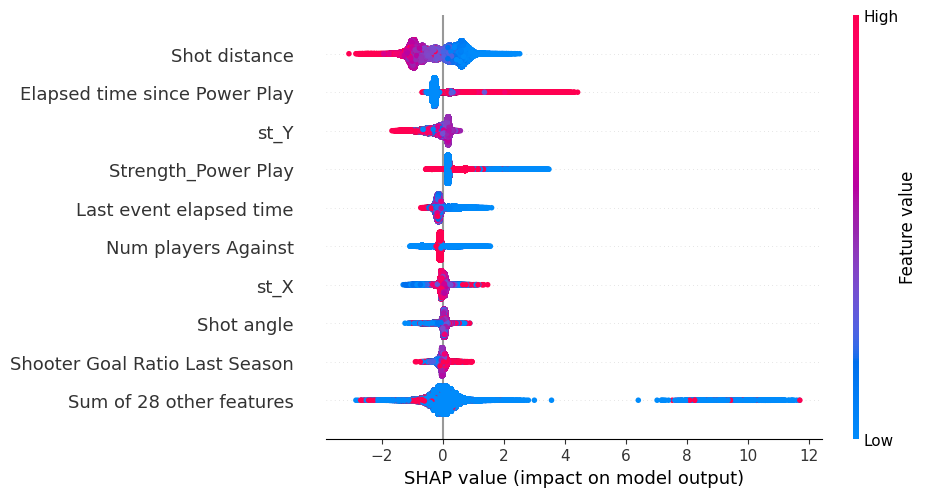

In [9]:
shap.plots.beeswarm(shap_values)

In [144]:
#----------------------------------------------
# Fit Random Forest With Random Forest selector
# ---------------------------------------------

# median
fill_nan = ColumnTransformer(transformers = [
    ('cat', SimpleImputer(strategy ='most_frequent'), nominal_columns + ordinal_columns),
    ('num', SimpleImputer(strategy ='median'), numerical_columns),
], remainder ='passthrough')

      
one_hot = ColumnTransformer(transformers = [
    ('enc', OneHotEncoder(sparse = False), list(range(len(nominal_columns)))),
], remainder ='passthrough')


# scaler
scaler = StandardScaler()

# features selectpr
selector = FeaturesSelector.SelectFromRandomForest()

# classifier
clf_forest = RandomForestClassifier(random_state=RANDOM_SEED)

# pipeline    
steps = [('fill_nan', fill_nan), ('one_hot', one_hot),  ('scaler', scaler), ('selector', selector), ("clf_forest", clf_forest)]
pipeline = Pipeline(steps=steps)

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_valid)

# Report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.95     55434
         1.0       0.70      0.11      0.19      5574

    accuracy                           0.91     61008
   macro avg       0.81      0.55      0.57     61008
weighted avg       0.90      0.91      0.88     61008



In [138]:
clf_xgboost = XGBClassifier.XGBClassifier()

eta = np.linspace(0.1, 1, 10)
gamma = np.linspace(0, 5, 10)
max_depth = range(2, 20, 2)
min_child_weight = range(1, 10, 1)

param_distributions = {
    'clf_xgboost__eta': eta,
    'clf_xgboost__gamma': gamma,
    'clf_xgboost__max_depth': max_depth,
    'clf_xgboost__min_child_weight': min_child_weight
}

In [ ]:
clf_mlp = MLPClassifier(
    learning_rate='adaptive', 
    batch_size=32, 
    early_stopping=True,
    random_state=RANDOM_SEED)

layer_sizes = [(5, 5, 5), (10, 10, 10), (15, 15, 15), (20, 20, 20)]
learning_rate_init = [1e-2, 1e-3, 1e-4]
solver = ['sgd', 'adam']
activation = ['sigmoid', 'relu']

param_distributions = {
    'clf_mlp__hidden_layer_sizes': layer_sizes,
    'clf_mlp__learning_rate_init': learning_rate_init,
    'clf_mlp__solver': solver,
    'clf_mlp__activation': activation
}

              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     55434
         1.0       0.19      0.76      0.31      5738

    accuracy                           0.68     61172
   macro avg       0.58      0.71      0.55     61172
weighted avg       0.89      0.68      0.74     61172



In [9]:
#----------------------------------------------
# Fit Random Forest With Random Forest selector
# ---------------------------------------------

# median
fill_nan = ColumnTransformer(transformers = [
    ('cat', SimpleImputer(strategy ='most_frequent'), nominal_columns + ordinal_columns),
    ('num', SimpleImputer(strategy ='median'), numerical_columns),
], remainder ='passthrough')

      
one_hot = ColumnTransformer(transformers = [
    ('enc', OneHotEncoder(sparse = False), list(range(len(nominal_columns)))),
], remainder ='passthrough')


# scaler
scaler = StandardScaler()

# features selectpr
selector = FeaturesSelector.SelectFromRandomForest()

# classifier
clf_mlp = MLPClassifier(
    hidden_layer_sizes = (10, 10, 10),
    learning_rate='adaptive', 
    batch_size=32, 
    early_stopping=True,
    random_state=RANDOM_SEED)

# pipeline    
steps = [('fill_nan', fill_nan), ('one_hot', one_hot),  ('scaler', scaler), ('selector', selector), ("clf_mlp", clf_mlp)]
pipeline = Pipeline(steps=steps)

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_valid)

# Report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     55434
         1.0       0.78      0.09      0.16      5574

    accuracy                           0.91     61008
   macro avg       0.85      0.54      0.56     61008
weighted avg       0.90      0.91      0.88     61008



In [43]:
#-------------------------------------
# Fit Random Forest With Selection PCA
# ------------------------------------

X_train, X_valid, y_train, y_valid = FeaturesManager.GetTrainValid()

# Remove outliers
X_train, y_train = OutliersManager.remove_outliers(X_train, y_train)
X_valid, y_valid = OutliersManager.remove_outliers(X_valid, y_valid)

# No scaler - inside PCA

# features selectpr
select_from_PCA = FeaturesSelector.SelectFromPCA(9)
select_from_PCA.fit(X_train, y_train)

X_train_new, y_train_new = select_from_PCA.transform(X_train, y_train)
X_valid_new, y_valid_new = select_from_PCA.transform(X_valid, y_valid)

# classifier
clf_forest = RandomForestClassifier(random_state=RANDOM_SEED)

# pipeline    
steps = [("forest", clf_forest)]
pipeline = Pipeline(steps=steps)

# Fit
pipeline.fit(X_train_new, y_train_new)

# Predict
y_pred = pipeline.predict(X_valid_new)

# Report
print(classification_report(y_valid_new, y_pred))

Cumulative explained variance with 9 components: 0.856691998547554
Cumulative explained variance with 9 components: 0.856691998547554
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     55434
         1.0       0.92      0.13      0.23      5574

    accuracy                           0.92     61008
   macro avg       0.92      0.57      0.59     61008
weighted avg       0.92      0.92      0.89     61008

